In [1]:
import os
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
import torch
import time
import torch.nn as nn
import torchvision.models as models
import time
import glob
import shutil
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, transform):
        self.transform = transform
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)

            img_lab = rgb2lab(img_original)
            img_ab = img_lab[:,:,1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2,0,1))).float()
        
            img_gray = img_lab[:,:,0]
            img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
            
        return img_gray, img_ab
    
    def __len__(self):
        return len(self.paths)

In [ ]:
# training data
path = r"/Users/huweiqi/Documents/CSCI2271/tiny-imagenet-200/train/"

dirs = os.listdir(path)
dirs = sorted(dirs)
# Define training and validation data paths
paths = []
for i in range(20):
    p1 = path + dirs[i] + '/images/'
    paths.extend(glob.glob(p1 + "/*.JPEG"))

rand_idxs = np.random.permutation(len(paths))
train_idxs = rand_idxs[:int(len(paths)*0.8)] 
val_idxs = rand_idxs[int(len(paths)*0.8):] 

train_paths = []
val_paths = []
for i in train_idxs:
    train_paths.append(paths[i])
for i in val_idxs:
    val_paths.append(paths[i])
print(len(train_paths), len(val_paths))

8000 2000


In [ ]:
train_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip()])
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])

train_image = ColorizationDataset(train_paths, train_transforms)
train_loader = torch.utils.data.DataLoader(train_image, batch_size=64, shuffle=True)

test_image = ColorizationDataset(val_paths, test_transforms)
test_loader = torch.utils.data.DataLoader(test_image, batch_size=64, shuffle=True)

### construct model

In [3]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        
        resnet = models.resnet18(num_classes=10)
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
    
        self.upsample = nn.Sequential(     
        nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
            
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
            
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
            
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
            
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
            
        nn.Upsample(scale_factor=2),
        nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.Softmax(dim=1),
        nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
        )
        
    def forward(self, input):
        input = (input-50)/100
        midlevel_features = self.midlevel_resnet(input)

        output = self.upsample(midlevel_features)
        return output * 110

In [4]:
model = ColorizationNet()
model

ColorizationNet(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input):
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy()
    color_image = color_image.transpose((1, 2, 0))
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()

In [ ]:
def validate(val_loader, model, criterion, epoch, use_gpu, test_loss):
    model.eval()

    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab) in enumerate(val_loader):
        data_time.update(time.time() - end)

        if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()

        output_ab = model(input_gray)
        loss = criterion(output_ab, input_ab)
        losses.update(loss.item(), input_gray.size(0))
        test_loss.append(loss.item())

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 25 == 0:
            print('Validate: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                 i, len(val_loader), batch_time=batch_time, loss=losses))
    return losses.avg

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, use_gpu, train_loss):
    print('Starting training epoch {}'.format(epoch))
    model.train()
    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    for i, (input_gray, input_ab) in enumerate(train_loader):


        if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()


        data_time.update(time.time() - end)


        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 25 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                  epoch, i, len(train_loader), batch_time=batch_time,
                 data_time=data_time, loss=losses)) 

In [ ]:
model = ColorizationNet().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
use_gpu = torch.cuda.is_available()
if use_gpu: 
    criterion = criterion.cuda()
    model = model.cuda()
epochs = 30

In [ ]:

train_loss = []
test_loss = []
for epoch in range(epochs):

    train(train_loader, model, criterion, optimizer, epoch, use_gpu, train_loss)
    with torch.no_grad():
        losses = validate(test_loader, model, criterion, epoch, use_gpu, test_loss)
   
    torch.save(model.state_dict(), r'models/small-model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/125]	Time 1.444 (1.444)	Data 1.024 (1.024)	Loss 278.1592 (278.1592)	
Epoch: [0][25/125]	Time 1.346 (1.357)	Data 0.932 (0.944)	Loss 238.8691 (291.1660)	
Epoch: [0][50/125]	Time 1.355 (1.355)	Data 0.939 (0.942)	Loss 264.9548 (287.1262)	
Epoch: [0][75/125]	Time 1.358 (1.354)	Data 0.944 (0.941)	Loss 333.7720 (283.7213)	
Epoch: [0][100/125]	Time 1.333 (1.353)	Data 0.920 (0.940)	Loss 183.1109 (280.8101)	
Finished training epoch 0
Validate: [0/32]	Time 1.051 (1.051)	Loss 239.3235 (239.3235)	
Validate: [25/32]	Time 1.053 (1.080)	Loss 253.3874 (289.8725)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/125]	Time 1.353 (1.353)	Data 0.943 (0.943)	Loss 203.2022 (203.2022)	
Epoch: [1][25/125]	Time 1.360 (1.357)	Data 0.948 (0.945)	Loss 252.3455 (281.3946)	
Epoch: [1][50/125]	Time 1.383 (1.357)	Data 0.968 (0.944)	Loss 267.5022 (284.4799)	
Epoch: [1][75/125]	Time 1.369 (1.356)	Data 0.953 (0.942)	Loss 375.1892 (278.4061)	
Epoch: [1][100/125]	Time 1.329

Epoch: [13][75/125]	Time 1.347 (1.348)	Data 0.936 (0.935)	Loss 266.2852 (256.6543)	
Epoch: [13][100/125]	Time 1.377 (1.351)	Data 0.965 (0.939)	Loss 198.0762 (260.9007)	
Finished training epoch 13
Validate: [0/32]	Time 1.101 (1.101)	Loss 283.1908 (283.1908)	
Validate: [25/32]	Time 1.131 (1.094)	Loss 291.8903 (285.6667)	
Finished validation.
Starting training epoch 14
Epoch: [14][0/125]	Time 1.363 (1.363)	Data 0.944 (0.944)	Loss 426.7824 (426.7824)	
Epoch: [14][25/125]	Time 1.358 (1.363)	Data 0.945 (0.951)	Loss 295.4070 (272.5889)	
Epoch: [14][50/125]	Time 1.352 (1.361)	Data 0.938 (0.949)	Loss 320.6302 (263.4663)	
Epoch: [14][75/125]	Time 1.342 (1.360)	Data 0.926 (0.948)	Loss 278.3283 (268.2636)	
Epoch: [14][100/125]	Time 1.357 (1.360)	Data 0.944 (0.947)	Loss 256.6059 (263.9268)	
Finished training epoch 14
Validate: [0/32]	Time 1.058 (1.058)	Loss 355.9696 (355.9696)	
Validate: [25/32]	Time 1.078 (1.087)	Loss 234.6898 (282.3327)	
Finished validation.
Starting training epoch 15
Epoch: [15]

Finished training epoch 26
Validate: [0/32]	Time 1.053 (1.053)	Loss 276.8249 (276.8249)	
Validate: [25/32]	Time 1.126 (1.088)	Loss 288.7616 (263.8143)	
Finished validation.
Starting training epoch 27
Epoch: [27][0/125]	Time 1.417 (1.417)	Data 0.981 (0.981)	Loss 214.2744 (214.2744)	
Epoch: [27][25/125]	Time 1.349 (1.370)	Data 0.938 (0.957)	Loss 226.8620 (250.1393)	
Epoch: [27][50/125]	Time 1.350 (1.364)	Data 0.938 (0.952)	Loss 267.0683 (246.1957)	
Epoch: [27][75/125]	Time 1.422 (1.363)	Data 1.009 (0.950)	Loss 251.9013 (243.2592)	
Epoch: [27][100/125]	Time 1.439 (1.368)	Data 1.025 (0.955)	Loss 297.9842 (246.9063)	
Finished training epoch 27
Validate: [0/32]	Time 1.060 (1.060)	Loss 186.6604 (186.6604)	
Validate: [25/32]	Time 1.062 (1.085)	Loss 219.0196 (283.9111)	
Finished validation.
Starting training epoch 28
Epoch: [28][0/125]	Time 1.390 (1.390)	Data 0.967 (0.967)	Loss 216.8043 (216.8043)	
Epoch: [28][25/125]	Time 1.365 (1.361)	Data 0.953 (0.949)	Loss 173.3194 (256.2952)	
Epoch: [28][5

<Figure size 640x480 with 0 Axes>

In [5]:
def resize_img(img, HW=(256,256), resample=3):
    return np.asarray(Image.fromarray(img).resize(HW, resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
    img_lab_orig = rgb2lab(img_rgb_orig)
    img_lab_rs = rgb2lab(img_rgb_rs)
    img_l_orig = img_lab_orig[:,:,0]
    img_l_rs = img_lab_rs[:,:,0]
    
    tensor_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
    tensor_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]
    return tensor_orig_l, tensor_rs_l

def postprocess_img(tensor_orig_l, out_ab, mode='bilinear'):
    shape_orig = tensor_orig_l.shape[2:]
    shape_out = out_ab.shape[2:]
    if (shape_orig[0]!=shape_out[0] or shape_orig[1]!=shape_out[1]):
        out_ab_orig = torch.nn.functional.interpolate(out_ab, size=shape_orig, mode='bilinear')
    else:
        out_ab_orig = out_ab
    
    out_lab_orig = torch.cat((tensor_orig_l, out_ab_orig), dim=1)
    return lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))

def visualize(model, path, j, HW=(256,256), use_gpu=False):
    gray_img = Image.open(path)
    img = np.asarray(gray_img)
    transform = transforms.Grayscale(3)
    tensor_orig_l, tensor_rs_l = preprocess_img(img, HW=HW)
    if use_gpu:
        tensor_orig_l, tensor_rs_l = tensor_orig_l.cuda(), tensor_rs_l.cuda()
    out_ab = model(tensor_rs_l)
    img_rec = postprocess_img(tensor_orig_l, out_ab)
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('ground truth')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(transform(gray_img))
    plt.title('gray scale')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_rec)
    plt.title('CNN colorized')
    plt.axis('off')
    plt.show()
    plt.imsave(arr=img_rec, fname='images/test{}.jpg'.format(j))
   

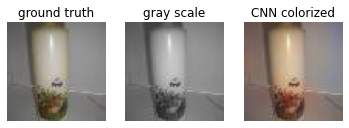

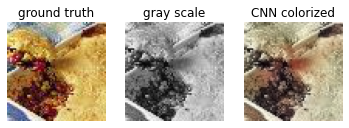

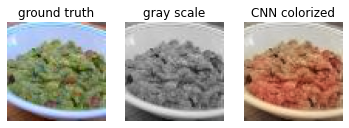

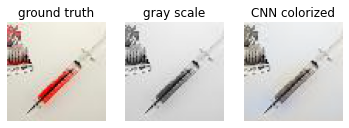

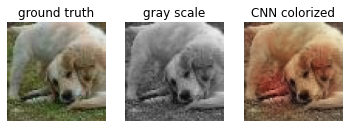

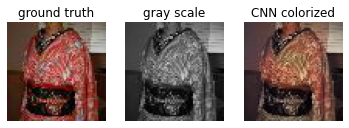

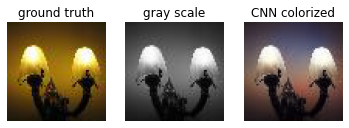

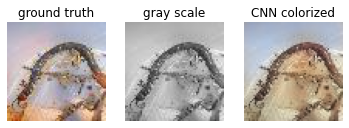

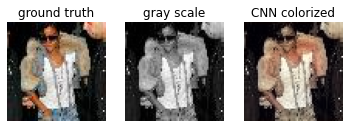

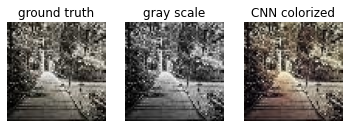

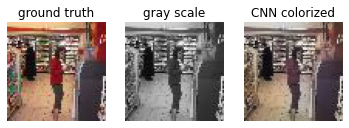

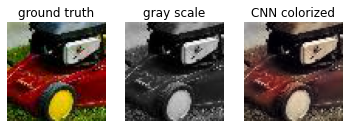

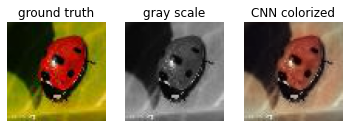

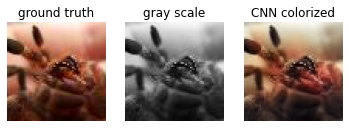

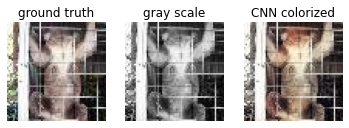

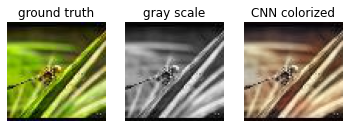

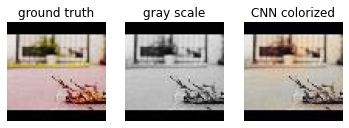

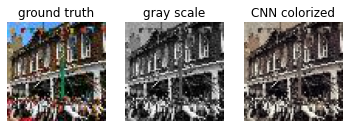

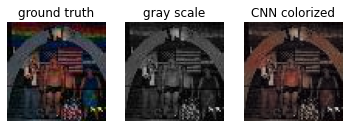

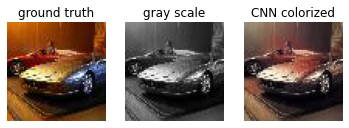

In [8]:
test_path = "/Users/huweiqi/Documents/CSCI2271/tiny-imagenet-200/test/images"
test_paths = glob.glob(test_path+"/*.JPEG")
test_paths = sorted(test_paths)
test_paths = test_paths[:20]
model.load_state_dict(torch.load("/models/small-model-epoch-30-losses-275.243.pth"))
model.eval()

j = 1
for i in test_paths:
    visualize(model.cuda(), i, j,HW=(224,224), use_gpu=True)
    j += 1
